<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [287]:
# Для создания запросов, подключения к БД, выполнения запросов, операций с результатами
import pandas as pd
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import text

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker


# Для работы с файлом настроек для подключения БД
import configparser

# Для парсинга городов-миллионников со страницы в Википедии
import requests
from bs4 import BeautifulSoup

In [288]:
# Создаем объект для хранения настроек подключения, и записываем в него настройки из локального файла settings.ini
config_settings = configparser.ConfigParser()
config_settings.read("settings.ini")

# Создаем переменные, для хранения настроек подключения и присваиваем им значения из локального файла-конфигуратора
DBNAME = config_settings["POSTGRESQL"]["DBNAME"]
USER = config_settings["POSTGRESQL"]["USER"]
PASSWORD = config_settings["POSTGRESQL"]["PASSWORD"]
HOST = config_settings["POSTGRESQL"]["HOST"]
PORT = config_settings["POSTGRESQL"]["PORT"]

In [289]:
# Создаем подключение к базе данных
url = f'postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}'
connection = create_engine(url).connect().execution_options(autocommit=True)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [290]:
# Код запроса, который подсчитывает общее количество вакансий в базе данных project_sql  в таблице vacancies
query_3_1 = f'''SELECT 
                    COUNT (vacancies.id)
                FROM 
                    public.vacancies
'''

In [291]:
# Получаем результат запроса и выводим искомое значение
count_vacancies = (pd.read_sql_query(text(query_3_1),connection)).values[0][0]
print('Количество вакансий в таблице vacancies равно', count_vacancies)

Количество вакансий в таблице vacancies равно 49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [292]:
# Код запроса, который подсчитывает общее количество работодателей в базе данных project_sql  в таблице employers
query_3_2 = f'''SELECT 
                    COUNT (employers.id)
                FROM 
                    public.employers                
'''

In [293]:
# Получаем результат запроса и выводим искомое значение
count_employers = (pd.read_sql_query(text(query_3_2), connection)).values[0][0]
print('Количество работодателей в таблице employers равно', count_employers)

Количество работодателей в таблице employers равно 23501


3. Посчитайте с помощью запроса количество регионов (таблица areas).

In [294]:
# Код запроса, который подсчитывает общее количество регионов в базе данных project_sql  в таблице areas
query_3_3 = f'''SELECT 
                    COUNT (areas.id)
                FROM 
                    public.areas                
'''

In [295]:
# Получаем результат запроса и выводим искомое значение
count_areas = (pd.read_sql_query(text(query_3_3), connection)).values[0][0]
print('Количество регионов в таблице areas равно', count_areas)

Количество регионов в таблице areas равно 1362


4. Посчитайте с помощью запроса количество сфер деятельности в базе (таблица industries).

In [296]:
# Код запроса, который подсчитывает общее количество сфер деятельности в базе данных project_sql  в таблице industries
query_3_4 = f'''SELECT 
                    COUNT (industries.id)
                FROM 
                    public.industries               
'''

In [297]:
# Получаем результат запроса и выводим искомое значение
count_industries = (pd.read_sql_query(text(query_3_4), connection)).values[0][0]
print('Количество сфер деятельности в таблице industries равно', count_industries)

Количество сфер деятельности в таблице industries равно 294


***

#### **Выводы по предварительному анализу данных**

База состоит из 5 таблиц: ***vacancies***, ***areas***, ***employers***, ***industries*** и ***emplouers_industries***. 

В таблице ***vacancies*** 10 столбцов и 49197 строк, содержащих информацию о вакансиях. Эта таблица наиболее динамичная по записям, так как вакансии чаще теряют актуальность или появляются новые, а также она хранит основную часть информации, которая требуется для обучения модели. Но 5 столбцов в ней  содержат текст, с которым моделям сложнее работать. 

Три таблицы (***areas***, ***industries*** и ***employers***) - это таблицы-справочники, хранящие информацию о городах, сферах деятельности и работодателях соответственно. Таблицы ***employers*** и ***areas***  связаны с таблицей ***vacancies*** через специальные идентификаторы. Таблица  ***industries*** связана с таблицей ***employers***  также через специальные идентификаторы, причем так как связь этих таблиц "много-ко-многим" в базе данных есть дополнительная промежуточная таблица ***emplouers_industries***, которая содержит исключительно ключи-идентификаторы, для образования пар "работодатель-сфера деятельности". 

По предварительному анализу данных можно сделать вывод, что для создание модели машинного обучения, которая будет рекомендовать вакансии клиентам агентства, претендующим на позицию Data Scientist база данных ***project_sql*** подходит, так как содержит довольное большое количество вакансий, предполагает охват 1362 городов и 23501 работодателей. Также база данных содержит всю необходимую информацию: сферу деятельности, чтобы определить те, в которых требуется позиция Data Scientist, город размещения вакантной должности, ключевые навыки и границы заработной платы, а также требования к опыту, график и тип трудоустройства. В дальнейшем нужно отсеить необходимые вакансии для обучения модели и определить достаточно ли этих данных.

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [298]:
# Код запроса, который возвращает таблицу с наименованием региона и количество вакансий в нем, в порядке убывания вакансий
query_4_1 = f'''SELECT
                    areas.name as area,
                    COUNT(vacancies.id) as cnt
                FROM 
                    public.vacancies as vacancies
                    JOIN public.areas as areas ON areas.id = vacancies.area_id
                GROUP BY areas.id
                ORDER BY cnt DESC
'''

In [299]:
# Получаем и выводим результат запроса
vacancies_by_area = pd.read_sql_query(text(query_4_1), connection)
display(vacancies_by_area)

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
764,Кизляр,1
765,Джизак,1
766,Эртиль,1
767,Арсеньев,1


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [300]:
# Код запроса, который посчитывает количество вакансий с хотя бы одним непустым полем зарплаты
query_4_2 = f'''SELECT 
                    COUNT(vacancies.id)
                FROM 
                    public.vacancies as vacancies
                WHERE (vacancies.salary_from IS NOT NULL) OR (vacancies.salary_to IS NOT NULL)                 
'''

In [301]:
# Получаем и выводим результат запроса
not_null_salary = (pd.read_sql_query(text(query_4_2), connection)).values[0][0]
print('Количество вакансий, где работодатель указал хотя бы одну границу оплаты труда:', not_null_salary)

Количество вакансий, где работодатель указал хотя бы одну границу оплаты труда: 24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [302]:
# Код запроса, который возвращает средние значения границ зарплатной вилки
query_4_3 = f'''SELECT 
                    AVG(vacancies.salary_from) as salary_from,
                    AVG(vacancies.salary_to) as salary_to
                FROM 
                    public.vacancies as vacancies             
'''

In [303]:
# Получаем и выводим результат запроса
mean_range_salary = pd.read_sql_query(text(query_4_3), connection)
print('Среднее значение для нижней границы зарплатной вилки:', round(mean_range_salary['salary_from'].values[0]))
print('Среднее значение для верхней границы зарплатной вилки:', round(mean_range_salary['salary_to'].values[0]))

Среднее значение для нижней границы зарплатной вилки: 71065
Среднее значение для верхней границы зарплатной вилки: 110537


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [304]:
# Код запроса, который возвращает таблицу с вариантами типа рабочего графика 
# и типа трудоустройства и подсчитывает количество вакансий с такими вариантами
query_4_4 = f'''SELECT 
                    vacancies.schedule as schedule,
                    vacancies.employment as employment,
                    COUNT(vacancies.id) as cnt
                FROM 
                    public.vacancies as vacancies
                GROUP BY vacancies.schedule, vacancies.employment
                ORDER BY cnt DESC
'''

In [305]:
# Получаем и выводим результат запроса
schedule_emloyment_combination = pd.read_sql_query(text(query_4_4), connection)
display(schedule_emloyment_combination)

,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


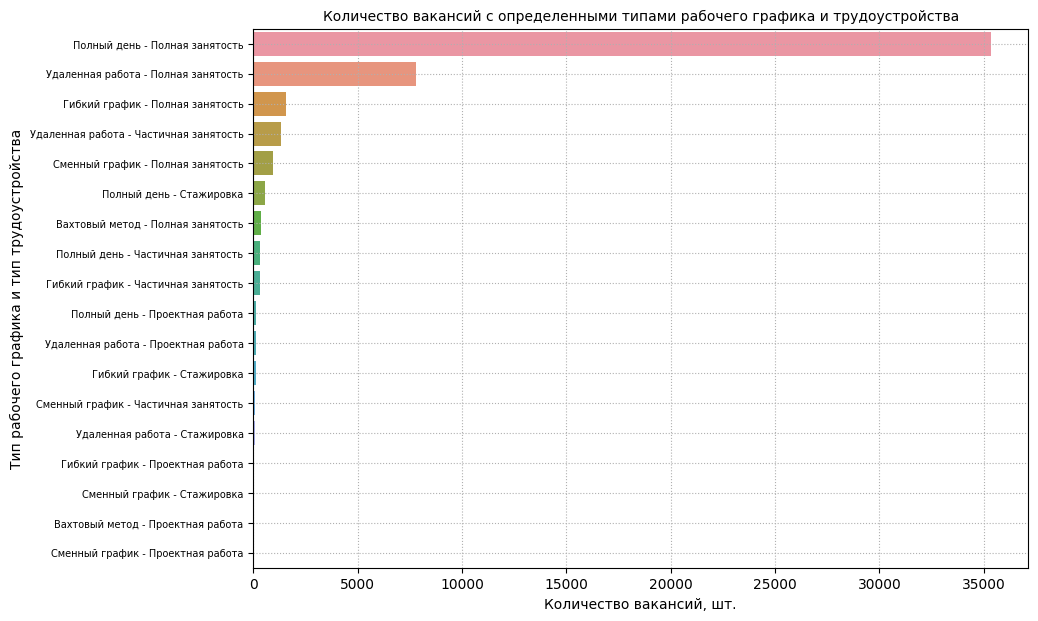

In [306]:
# Создаем столбец с парами типов трудоустройства и графика
schedule_emloyment_combination['options'] = schedule_emloyment_combination['schedule']+" - "+schedule_emloyment_combination['employment']

# Выводим столбчатую диаграмму вариантов трудоустройства и графика и кол-во вакансий для них
fig, axes = plt.subplots(figsize=(10, 7))
barplot = sns.barplot(
    data=schedule_emloyment_combination,
    x='cnt',
    y='options',
    orient='h'
)
barplot.set_title('Количество вакансий с определенными типами рабочего графика и трудоустройства', fontsize=10)
barplot.tick_params(axis='y', labelsize=7)
barplot.set_xlabel('Количество вакансий, шт.', fontsize=10)
barplot.set_ylabel('Тип рабочего графика и тип трудоустройства', fontsize=10)
barplot.xaxis.set_major_locator(ticker.MultipleLocator(5000))
barplot.grid(linestyle=':')

5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [307]:
# Код запроса, который возвращает таблицу с вариантами опыта работы и количеством вакансий,
# в которых этот вариант указан
query_4_5 = f'''SELECT 
                    vacancies.experience as experience,
                    COUNT(vacancies.id) as cnt
                FROM 
                    public.vacancies as vacancies
                WHERE vacancies.experience IS NOT NULL
                GROUP BY vacancies.experience
                ORDER BY cnt ASC
'''

In [308]:
# Получаем и выводим результат запроса
experience_option = pd.read_sql_query(text(query_4_5), connection)
display(experience_option)

,experience,cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


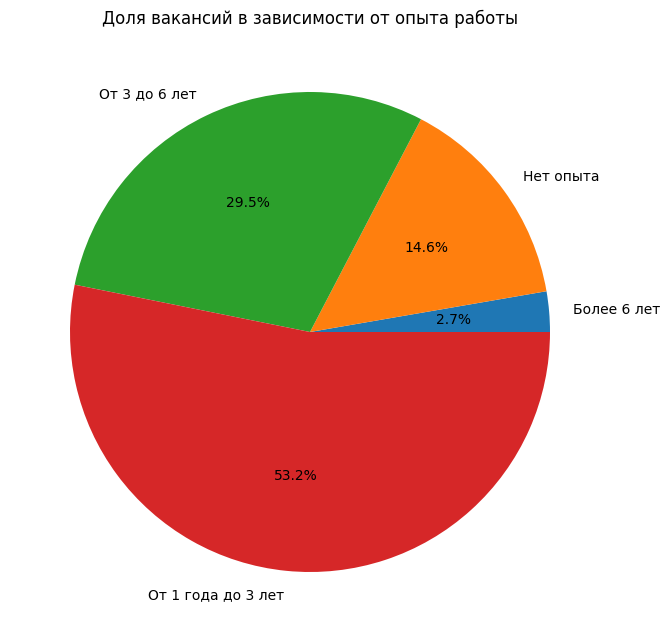

In [309]:
# Для визуализации строим круговую диаграмму доли вакансий в зависимости от опыта работы
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes((1, 1, 1, 1))
pie = ax.pie(
    experience_option['cnt'],
    labels=experience_option['experience'],
    autopct='%1.1f%%'
)
ax.set_title('Доля вакансий в зависимости от опыта работы', fontsize=12)
plt.show(pie)

***

#### **Выводы по детальному анализу вакансий**

Из 1362 регионов действующие вакансии есть только в 769, что составляет примерно 57% от общего количества регионов. При этом 80% вакансий территориально находятся в первых 50 городах (в рейтинге по количеству вакансий), что объяснимо наличием городов-миллионников, в которых больше работодателей. 

Только в 10102 (~20%) вакансиях работодатель указал обе границы оплаты труда, при этом только 24073 (~49%) вакансий имеют информацию хотя бы об одной границе оплаты труда, то есть больше половины вакансий не имеет информации, которая больше всего интересует соискателей, причиной этого может быть политика компании, когда заработную плату назначают по итогам собеседования, если в компанию требуется руководитель, его зарплату не указывают по причине большой разницы в зарплатах рядовых сотрудников и руководства, либо в компании настолько низкая оплата труда, что она не выдержит конкуренции с другими работодателями, либо компания не проводила исследования или не готова обозначить оплату сотрудника по требуемой вакансии. В данном вопросе требуются дополнительные исследования, чтобы понять, для какого количества вакансий, где требуется позиция Data Scientist границы указаны, и подходит ли это количество, чтобы обучить модель. Но предварительно можно сделать вывод, что признаки границ заработной платы в текущем варианте не подходят для обучения модели, так как не выполнено условие 60% данных, требуемых для обучения.То есть в сыром виде использовать признаки заработной платы невозможно.

Львиная доля вакансий (35367) предполагает полную занятость и полный рабочий день, на втором месте удаленная работа и полная занятость. Эти типы трудоустроцства и графика являются самыми распространенными и часто присущи вакансиям Data Scientist. В дальнейшем можно исследовать более детально какие типы трудоустройства и графика работы предлагают работодатели для позиции дата-сайентиста. Из анализа резюме мы знаем, что полная занятость и полный рабочий день являются самыми популярными и с самыми большими ожиданиями в заработной плате вариантами, поэтому в дальнейшем можно исследовать какую заработную плату предлагают работодатели для самых популярных вариантов графика и в частности что указано для вакансий дата-сайентистов. Поскольку данные о графике и типе трудоустройства указаны во всех вакансиях, то эти данные хорошо подходят для обучения модели.

Большая часть вакансий по опыту работы находится в препределах от 1 года до 6 лет (от 1 года до 3 лет - 53.2% и от 3 до 6 лет - 29.5%), из исследования резюме мы знаем, что медианный опыт работы составляет 100 месяцев (~8 лет), а значит вакансии в нашей базе данных подходят более 80% соискателей, что хорошо для обучения модели. Для дальнейшего исследования стоит рассмотреть более детально какой опыт работы хотят видеть работодатели ищущие дата-сайентистов, а также изучить вакансии для начинающих дата-сайентистов, в том числе в разрезе разаботной платы.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [310]:
# Код запроса, для получения рейтинга работодателей по количеству вакансий (возвращаем только 1 и 5 места)
query_5_1 = f'''(SELECT 
                    employers.name as employer,
                    COUNT(vacancies.id) as cnt
                FROM 
                    public.vacancies as vacancies
                    JOIN public.employers as employers ON employers.id = vacancies.employer_id
                GROUP BY employers.id
                ORDER BY cnt DESC
                LIMIT 1)
                UNION ALL
                (SELECT 
                    employers.name as employer,
                    COUNT(vacancies.id) as cnt
                FROM 
                    public.vacancies as vacancies
                    JOIN public.employers as employers ON employers.id = vacancies.employer_id
                GROUP BY employers.id
                ORDER BY cnt DESC
                OFFSET 4 LIMIT 1)
'''

In [311]:
# Вызываем и выводим результат запроса
employers_1_and_5_places = pd.read_sql_query(text(query_5_1), connection)
display(employers_1_and_5_places)

,employer,cnt
0,Яндекс,1933
1,Газпром нефть,331


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [312]:
# Код запроса, который возвращает имена регионов, в которых отсутствуют вакансии в порядке убывания количества работодателей
query_5_2 = f'''SELECT
                    areas.name,
                    COUNT(vacancies.id) as cnt_vacancies,
                    COUNT(DISTINCT employers.id) as cnt_employers
                FROM 
                    public.areas as areas
                    LEFT JOIN public.vacancies as vacancies ON vacancies.area_id = areas.id
                    JOIN public.employers as employers ON employers.area = areas.id
                    WHERE vacancies.id IS NULL
                GROUP BY areas.id
                ORDER BY cnt_vacancies NULLS FIRST, cnt_employers DESC
'''

In [313]:
# Вызываем запрос и выводим результат запроса
employers_and_vacancies_by_areas = pd.read_sql_query(text(query_5_2), connection)
display(employers_and_vacancies_by_areas)

,name,cnt_vacancies,cnt_employers
0,Россия,0,410
1,Казахстан,0,207
2,Московская область,0,75
3,Краснодарский край,0,19
4,Беларусь,0,18
...,...,...,...
181,Витебская область,0,1
182,Ивацевичи,0,1
183,Дубровно,0,1
184,Буда-Кошелево,0,1


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [314]:
# Код запроса, который возвращает рейтинг работодателей по количеству регионов, в которых они публикуют вакансии
query_5_3 = f'''SELECT
                    employers.name as employers,
                    COUNT(DISTINCT vacancies.area_id) as cnt_areas_of_vacancies
                FROM 
                    public.employers as employers
                    LEFT JOIN public.vacancies as vacancies ON vacancies.employer_id = employers.id
                GROUP BY employers.id
                ORDER BY cnt_areas_of_vacancies DESC
'''

In [315]:
# Вызываем запрос и выводим его результат
areas_of_employers_vacancies = pd.read_sql_query(text(query_5_3), connection)
display(areas_of_employers_vacancies)

,employers,cnt_areas_of_vacancies
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
23496,Но Смокинг,0
23497,МАСТЕРСКАЯ CREED,0
23498,Dzing Finance,0
23499,КОРС,0


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [316]:
# Код запроса, для определения количества работодателей, не указавших свою сферу деятельности
query_5_4 = f'''SELECT 
                    COUNT(DISTINCT employers.id)
                FROM 
                    public.employers as employers
                    LEFT JOIN public.employers_industries as emp_ind ON emp_ind.employer_id = employers.id
                WHERE emp_ind.industry_id IS NULL
'''

In [317]:
# Вызов запроса и вывод результата
employers_without_industries = (pd.read_sql_query(text(query_5_4), connection)).values[0][0]
print('Количество работодателей, для которых не указана сфера деятельности:', employers_without_industries)

Количество работодателей, для которых не указана сфера деятельности: 8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [318]:
# Код запроса, выводящий название компании на третьем месте в алфавитном перечне компаний с 4мя сферами деятельности
query_5_5 = f'''SELECT
                    employers.name as name
                FROM 
                    public.employers as employers
                    JOIN public.employers_industries as emp_ind ON emp_ind.employer_id = employers.id
                GROUP BY employers.id
                HAVING COUNT(emp_ind.industry_id)=4
                ORDER BY name
                OFFSET 2 LIMIT 1                
'''

In [319]:
# Вызываем запрос и выводим результат запроса
third_employer_with_4_industries = (pd.read_sql_query(text(query_5_5), connection)).values[0][0]
print('Компания, находящаяся на 3 месте в списке компаний, у которых 4 сферы деятельности:', third_employer_with_4_industries)

Компания, находящаяся на 3 месте в списке компаний, у которых 4 сферы деятельности: 2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [320]:
# Код запроса, подсчитывающий количество компаний со ферой деятельности - Разработка программного обеспечения
query_5_6 = f'''SELECT
                    COUNT(employers.id)
                FROM 
                    public.employers_industries as emp_ind
                    JOIN public.employers as employers ON employers.id = emp_ind.employer_id
                    JOIN public.industries as industries ON industries.id = emp_ind.industry_id
                WHERE industries.name LIKE 'Разработка программного обеспечения'    
'''

In [321]:
# Вызываем запрос и выводим результат запроса
count_employers_by_mask = (pd.read_sql_query(text(query_5_6), connection)).values[0][0]
print('Количество работодателей, у которых в качестве сферы деятельности указана Разработка программного обеспечения:', 
      count_employers_by_mask
)

Количество работодателей, у которых в качестве сферы деятельности указана Разработка программного обеспечения: 3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [322]:
# Код для получения списка городов-милионников
url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
contents = requests.get(url).text
soup = BeautifulSoup(contents, 'lxml')
million_cities = []
for i in range(2,18):
    city = soup.select(f'#mw-content-text > div > table.standard.sortable > tbody > tr:nth-child({i}) > td:nth-child(2) > a')
    city = (str(city[0])).split('"')
    million_cities.append(city[3])
    i += 1
million_cities = tuple(million_cities)

In [323]:
# Код запроса, который подсчитывает количество вакансий компании Яндекс в городах-миллионниках, 
# а также общее количество вакансий этой компании
query_5_7 = f'''SELECT
                    areas.name as citi_name,
                    COUNT(vacancies.id) as cnt
                FROM
                    public.vacancies as vacancies
                    JOIN public.employers as employers ON employers.id = vacancies.employer_id
                    AND employers.name = 'Яндекс'
                    JOIN public.areas as areas ON areas.id = vacancies.area_id
                    AND areas.name in {million_cities}
                GROUP BY areas.name
                UNION ALL
                SELECT
                    'Total',
                    COUNT(*) as cnt
                FROM
                    public.vacancies as vacancies
                    JOIN public.employers as employers ON employers.id = vacancies.employer_id
                    AND employers.name = 'Яндекс'
                    JOIN public.areas as areas ON areas.id = vacancies.area_id
                    AND areas.name in {million_cities}
                ORDER BY cnt ASC
'''

In [324]:
# Вызываем запрос и выводим результат его выполнения
yandex_vacancies = pd.read_sql_query(text(query_5_7), connection)
print('Количество вакансий компании "Яндекс"  в городах-миллионниках: \n', yandex_vacancies)

Количество вакансий компании "Яндекс"  в городах-миллионниках: 
           citi_name  cnt
0              Омск   21
1         Челябинск   22
2        Красноярск   23
3         Волгоград   24
4             Пермь   25
5            Казань   25
6    Ростов-на-Дону   25
7               Уфа   26
8            Самара   26
9         Краснодар   30
10          Воронеж   32
11      Новосибирск   35
12  Нижний Новгород   36
13     Екатеринбург   39
14  Санкт-Петербург   42
15           Москва   54
16            Total  485


***

#### **Выводы по анализу работодателей**

Исследование работодателей показало, что наибольшее количество вакансий  размещено компанией *"Яндекс"* - 1933 из них четверть вакансий в городах-миллионниках. При этом у компании *"Яндекс"*, самый большой территориальный охват, ее вакансии размещены в 181 регионах, на втором месте по территориальному охвату компания *"Ростелеком"*. 

В первую двойку регионов, в которых нет вакансий, входят регионы: Россия и Казахстан - географически они включают в себя области и округа, то есть представляют из себя множества других регионов этой же таблицы. И поскольку вакансии можно привязать к более точным географическим местоположениям, работодатели не указывают обобщающие регионы. Вместе с тем, в данных регионах зарегестрировано 617 работодателей, что может объяснятся тем, что крупные компании, которые работают в разных регионах или имеют распределенную сеть филиалов, но головной офис один, в качестве региона регистрации указывают более крупный географический объект. Либо международные компании ищут соискателя по всей стране. Либо таким образом работодатели пытаются скрыть поиск вакансии от конкурентов или своих сотрудников. Интересно посмотреть на количество работодателей, у которых не совпадает регион регистрации и регион размещения вакансий, а также узнать в каких еще регионах публикуют вакансии работодатели, находящие в первой пятерке рейтинга, который мы получили в запросе **query_5_2**.

У 8419 (~35.8%) работодателей не указана сфера деятельности, что также объясняется желанием скрыть поиск сотрудников от конкурентов или уже работающих сотрудников, а также причиной этому может быть новая сфера деятельности, которой нет в справочнике ***industries***. Интересно посмотреть рейтинг компаний, не указавших ни одной сферы деятельности, по количеству вакансий, которые они предлагают и подходят ли эти вакансии для дата-сайентиста.

Сфера деятельности "Разработка программного обеспечения" указана у 3553 работодателей в нашей базе данных, что составляет 15% от всех работодателей, интересно будет узнать, сколько вакансий у этих работодателей, а также подходят ли они для рекомендаций на позицию Data Scientist. В любом случае на данном этапе анализа можно сделать вывод, что шестая часть работодателей точно связана с информационными технологиями.

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [325]:
# Код запроса, который возвращает количество вакансий, в которых содержатся слова 'data' или 'данн'
query_6_1 = f'''SELECT
                    COUNT(id) as cnt
                FROM
                    public.vacancies as vacancies
                WHERE name ILIKE '%data%' OR name ILIKE '%данн%'
'''

In [326]:
# Выполняем запрос и выводим его результат
datas_vacancies = pd.read_sql_query(text(query_6_1), connection).values[0][0]
print('Количество вакансий, имеющих отношение к данным:', datas_vacancies)

Количество вакансий, имеющих отношение к данным: 1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [327]:
# Создаем словарь сортировки названий вакансий
ds_sort = ['%data scientist%', '%data science%', '%исследователь данных%', '%machine learning%', '%машинн%обучен%']

# Код запроса, который подсчитывает количество вакансий для начинающих дата-сайентистов
query_6_2 = f'''SELECT
                    COUNT(id) as cnt
                FROM
                    public.vacancies as vacancies
                WHERE (name ILIKE ANY (ARRAY{ds_sort}) OR name LIKE '%ML%')
                    AND name NOT ILIKE '%HTML%'
                    AND (name ILIKE '%junior%' OR experience LIKE '%Нет опыта%' OR employment LIKE '%Стажировка%')                    
'''

In [328]:
# Выполняем запрос и выводим результат
junior_DS_vacancies = pd.read_sql_query(text(query_6_2), connection).values[0][0]
print('Количество вакансий для начинающего дата-сайентиста:', junior_DS_vacancies)

Количество вакансий для начинающего дата-сайентиста: 51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [329]:
# Код запроса, который возвращает количество вакансий с ключевыми навыками SQL и postgres
query_6_3 = f'''SELECT
                    COUNT(id) as cnt
                FROM
                    public.vacancies as vacancies
                WHERE (name ILIKE ANY (ARRAY{ds_sort}) OR name LIKE '%ML%')
                    AND name NOT ILIKE '%HTML%'
                    AND (key_skills ILIKE '%SQL%' OR key_skills ILIKE '%postgres%')
'''

In [330]:
# Выполняем запрос и выводим результат его выполнения
sql_DS_vacancies = pd.read_sql_query(text(query_6_3), connection).values[0][0]
print('Количество вакансий для дата-сайентиста с навыками SQL и posgres:', sql_DS_vacancies)

Количество вакансий для дата-сайентиста с навыками SQL и posgres: 201


4. Проверьте, насколько популярен Python в требованиях работодателей к DS. Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [331]:
# Код запроса, который возвращает количество вакансий с навыком Python для дата-сайентистов
query_6_4 = f'''SELECT
                    COUNT(id) as cnt
                FROM
                    public.vacancies as vacancies
                WHERE (name ILIKE ANY (ARRAY{ds_sort}) OR name LIKE '%ML%')
                    AND name NOT ILIKE '%HTML%'
                    AND key_skills ILIKE '%python%'
'''

In [332]:
# Вызываем запрос и выводим результат его выполнения
python_DS_vacancies = pd.read_sql_query(text(query_6_4), connection).values[0][0]
print('Количество вакансий для дата-сайентиста с навыком python:', python_DS_vacancies)

Количество вакансий для дата-сайентиста с навыком python: 351


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [333]:
# Код запроса, который возвращает количество навыков, которое в среднем указывают в вакансиях для дата-сайентистов
query_6_5 = f'''SELECT
                    AVG(LENGTH(key_skills)-LENGTH(REPLACE(key_skills, CHR(9), ''))+1)
                FROM
                    public.vacancies as vacancies
                WHERE (name ILIKE ANY (ARRAY{ds_sort}) OR name LIKE '%ML%')
                    AND name NOT ILIKE '%HTML%'
                    AND key_skills IS NOT NULL
'''

In [334]:
# Выполняем запрос и выводим результат
mean_key_skills = pd.read_sql_query(text(query_6_5), connection).values[0][0]
print('Среднее количество ключевых навыков в вакансиях для дата-сайентиста:', round(mean_key_skills, 2))

Среднее количество ключевых навыков в вакансиях для дата-сайентиста: 6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [335]:
# Код запроса, который выводит среднюю заработную плату для вакансии дата-сайентиста с опытом работы от 3 до 6 лет
query_6_6 = f'''SELECT
                    DISTINCT experience,
                    AVG(COALESCE((salary_from + salary_to)/2, salary_to, salary_from, 0)) as mean_salary
                FROM
                    public.vacancies as vacancies
                WHERE (name ILIKE ANY (ARRAY{ds_sort}) OR name LIKE '%ML%')
                    AND name NOT ILIKE '%HTML%'
                    AND (salary_to IS NOT NULL OR salary_from IS NOT NULL)
                GROUP BY experience
'''

In [336]:
# Вызываем запрос и выводим результат выполнения
mean_ds_salary = pd.read_sql_query(text(query_6_6), connection)
print('Дата-сайентист с опытом работы от 3 до 6 лет может расчитывать на зарплату:',round(mean_ds_salary.values[2][1]))

Дата-сайентист с опытом работы от 3 до 6 лет может расчитывать на зарплату: 243115


***

#### Вывод по предметному анализу

Исходя из полученных данных можно сделать вывод, что всего 3.6% вакансий имеют отношение к данным. Поскольку для условия включения данных использовались только 'data'  и 'данн', то конечно это не все вакансии, так как в данном случае не учитываются, например, такие сокращения, как 'БД' или 'DB' и много других вариантов. Поэтому строго говоря считать, что всего 3.6% вакансий подходят для обучения модели будет неверно, скорее 3.6% точно подходят, но точное число вакансий неизвестно. Для определения более точного количества вакансий, которые относятся к данным, нужно проанализировать часто встречающиеся слова в вакансиях, где работодатель подходящую сферу деятельности или ключевые навыки подходят для работы с данными. Но для этого нужно отдельно более тщательно исследовать сферы деятельности и ключевые навыки, с приминением не только возможностей SQL, но и с использованием возможностей Python, что выходит за рамки данной работы. 

Дальнейшие исследования также упрощены, поскольку используются строго возможности SQL, но тем не менее благодаря простым запросам удалось отсеить 51 вакансию для начинающего дата-сайентиста. Что для соискателя довольно неплохой выбор, так как большее количество было бы сложнее изучить вручную, на предмет привлекательности той или иной вакансии. То есть простой запрос SQL сработал в качестве хорошего фильтра вакансий и сузил для соискателя базу из 49197 вакансий до приемлемых 51. 

Также с использованием запросов можно было легко отсеить вакансии по желаемым ключевым навыкам. В дальнейшем с помощью подобных запросов можно составить, например, словарь ключевых навыков, соответствующих профессии дата-сайентиста и при поиске вакансий пользоваться словарем, для более точного поиска и более эффективного обучения модели.

Относительно средней заработной платы: как мы уже выяснили в сыром виде данных для обучения модели в нашей базе недостаточно, нужны специальные методы для заполнения недостающей информации, либо этот признак стоит исключить. Но поскольку размер заработной платы является практически главным фактором для соискателя при принятии решения, то исключение признака будет неправильно. Из исследования вакансий нам известно, что большинство соискателей желают заработную плату в диапазоне от 48 до 53 тысяч рублей, при этом среднюю заработную плату, которую предлагают работодатели для дата-сайентиста с опытом работы от 3 до 6 лет мы получили ~ 243 тысячи рублей, что значительно превосходит ожидания большинства соискателей. Конечно это не совсем правильное сравнение, так как мы не рассматриваем резюме, только по позициям Data Science, а также не рассматриваем опыт работы в резюме, но тем не менее можно сделать вывод, что заработная плата для позиций дата-сайентиста в среднем гораздо выше, чем в большинстве других вакансий.

# Общий вывод по проекту

Из рейтинга регионов по количеству вакансий мы можем рассчитать, что ~80% всех вакансий в нашей базе данных сосредоточены в первых 50 регионах нашего рейтинга, при этом ~49% всех вакансий относятся к городам-миллионникам. Что объясняется размещением в этих городах более крупных компаний, а также большим количеством работодателей, так как в таких городах больше клиентов у компаний, лучше логистическая,транспортная сфера и информационно-технологическая базы.

Вместе с тем в нашей базе данных очень много пробелов, так отсутствует ~36% сведений о сферах деятельности работодателя, и ~51% информации об оплате труда, что без дополнительной обработки данных делает нашу базу в сыром виде не пригодной для обучения модели.

Кроме того мы выяснили, что менее 1% вакансий содержат в названии слова, типичные для позиций Data Scientist и еще меньше вакансий для начинающих дата-сайентистов, таких вакансий мы получили только 51. Что слишком мало для обучения модели, а значит необходимо искать решения, для более точного отбора данных, возможно комбинировать несколько методов и подходов, либо наша база данных в принципе не подходит для обучения модели.

Запросы SQL во многих случаях позволили нам быстрее и точнее получить искомую информацию, в сравнении с инструментами, которыми аппелирует Python без использования SQL. Вместе с тем только запросов SQL не достаточно для исследования и выбоки необходимых данных. Лучшим будет использование комбинации из запросов SQL и инструментов, которые предлагает Python.

В дальнейшем стоит подробнее изучить наименования вакансий и ключевые навыки, так как в наших запросах, например, не учитывалось сокращение БД (база данных) и много других слов, которые используют при размещении вакансий, подходящих для дата-сайентиста. 

# Дополнительные исследования

1. Количество вакансий, где регион регистрации работодателя не совпадает с регионом вакансии.

In [337]:
query_extra_1 = f'''SELECT 
                    COUNT(vacancies.id)
                FROM 
                    public.vacancies as vacancies
                    JOIN public.employers as employers ON employers.id = vacancies.employer_id
                WHERE vacancies.area_id <> employers.area                  
'''

In [338]:
different_area = (pd.read_sql_query(text(query_extra_1), connection)).values[0][0]
print('Количество вакансий, где регион вакансии не совпадает с регионом регистрации работодателя:', different_area)

Количество вакансий, где регион вакансии не совпадает с регионом регистрации работодателя: 23820


**Вывод**: 48.4% вакансий размещаются в регионах, отличных от региона работодателя. Это объясняется большим количеством компаний, которые имеют филиалы, распределенные по рахным географическим объектам, а также много иностранных компаний, которые ищут сотрудников для представительства в другой стране. Для России характерна централизация головных компаний в Москве, при этом сотрудники могут быть привязаны к конкретным географическим объектам, например добыча нефти осуществляется сотрудниками в местах, где она обнаружена, а не где зарегистрирована  компания. Также некоторые компании набирают сотрудников в регионах с низким показателем средней заработной платы для экономии, так часто поступают компании при организации call-центров.

2. Выведем ТОП-20 по количеству вакансий работодателей, у которых не указана сфера деятельности, чтобы понять возможные причины.

In [339]:
# Код запроса, ТОП-20 работодателей, не указавших сферу деятельности по убыванию количества вакансий
query_extra_2 = f'''SELECT 
                    DISTINCT employers.name as employers_name,
                    count (vacancies.id) as cnt_vacancies
                    
                FROM 
                    public.employers as employers
                    LEFT JOIN public.employers_industries as emp_ind ON emp_ind.employer_id = employers.id
                    JOIN public.vacancies as vacancies on vacancies.employer_id = employers.id
                WHERE emp_ind.industry_id IS NULL
                GROUP BY employers.id
                ORDER BY count (vacancies.id) DESC
'''

In [340]:
# Вызов запроса и вывод результата
employers_without_industries = (pd.read_sql_query(text(query_extra_2), connection))
display(employers_without_industries.head(20))

,employers_name,cnt_vacancies
0,Спецремонт,151
1,Поляков Денис Иванович,127
2,"Иннотех, Группа компаний",122
3,DNS Головной офис,72
4,ООО ЕФИН,71
5,АЛНАС,69
6,Диплей,68
7,"РУСАЛ, Центр подбора персонала",54
8,Employcity,47
9,Ростелеком Информационные Технологии,46


**Вывод**: Как можно заметить среди компаний, не указавших ни одной сферы деятельности довольно много компаний, которые связаны с IT сферой. Причем часть из них довольно крупные подразделения. Так как практически у трети работодателей не указана сфера деятельности, а их суммарное количество вакансий составляет 10084 (20.5%), то в дальнейшем следует попробовать заполнить недостающие данные исходя из названия компаний, а также исходя из названия и ключевых навыков в вакансиях, которые они размещают.

3. Средняя заработная плата в зависимости от типа трудоустройства.

In [341]:
# Код запроса, который возвращает среднюю заработную плату для каждого типа трудоустройства
query_extra_3 = f'''SELECT
                    employment as employment,
                    ROUND(AVG(COALESCE((salary_from + salary_to)/2, salary_to, salary_from, 0))) as mean_salary
                FROM
                    public.vacancies as vacancies
                WHERE salary_to IS NOT NULL OR salary_from IS NOT NULL
                GROUP BY employment
                ORDER BY mean_salary DESC
'''

In [342]:
# Вызов запроса и вывод результата
mean_salary_by_employment = (pd.read_sql_query(text(query_extra_3), connection))
display(mean_salary_by_employment)

,employment,mean_salary
0,Проектная работа,92086.0
1,Полная занятость,88240.0
2,Стажировка,37249.0
3,Частичная занятость,31566.0


**Вывод**: Из полученных данных можно сделать вывод, что наиболее оплачиваемой является проектная работа, что можно объяснить тем, что как правило на такие работы приглашают узких специалистов, которые изначально ценятся выше, а также тем, что проект по времени может занимать больше месяца, а оплата указана за проект, а не за месяц работ над проектом. 

На втором месте самый популяный и с точки зрения работодателей и с точки зрения соискателей тип трудоустройства, где средняя заработная плата предлагается 88 тысяч рублей, что выше ожидаемой соискателями заработной платы (в предыдущем проекте мы выяснили, что это ~60 тысяч рублей), что в свою очередь означает, что большинство вакансий подходят соответсвующим соискателям. 

Также можно заметить, что частичную занятость работодатели оценивают ниже, чем стажировку, что также логично, ведь стажер хоть и требует большего контроля, но при этом работает полный день и в дальнейшем может перейти на полную занятость, сотрудник с частичной занятостью в свою очередь, как правило не переходит на полный день, а данная вакансия рассматривается им в качестве подработки.

4. Средняя заработная плата в зависимости от количества требуемых навыков.

In [343]:
# Код запроса, который возвращает среднюю заработную плату для всех вариантов количества ключевых навыков
query_extra_4 = f'''SELECT
                    (LENGTH(key_skills)-LENGTH(REPLACE(key_skills, CHR(9), ''))+1) as cnt_key_skills,
                    ROUND(AVG(COALESCE((salary_from + salary_to)/2, salary_to, salary_from, 0))) as mean_salary
                FROM
                    public.vacancies as vacancies
                WHERE key_skills IS NOT NULL AND (salary_to IS NOT NULL OR salary_from IS NOT NULL)
                GROUP BY cnt_key_skills
                UNION ALL
                SELECT
                    '0',
                    ROUND(AVG(COALESCE((salary_from + salary_to)/2, salary_to, salary_from, 0))) as mean_salary
                FROM
                    public.vacancies as vacancies
                WHERE key_skills IS NULL AND (salary_to IS NOT NULL OR salary_from IS NOT NULL)
                ORDER BY mean_salary DESC
'''

In [344]:
# Вызов запроса и получение данных
mean_salary_by_key_skills = (pd.read_sql_query(text(query_extra_4), connection))

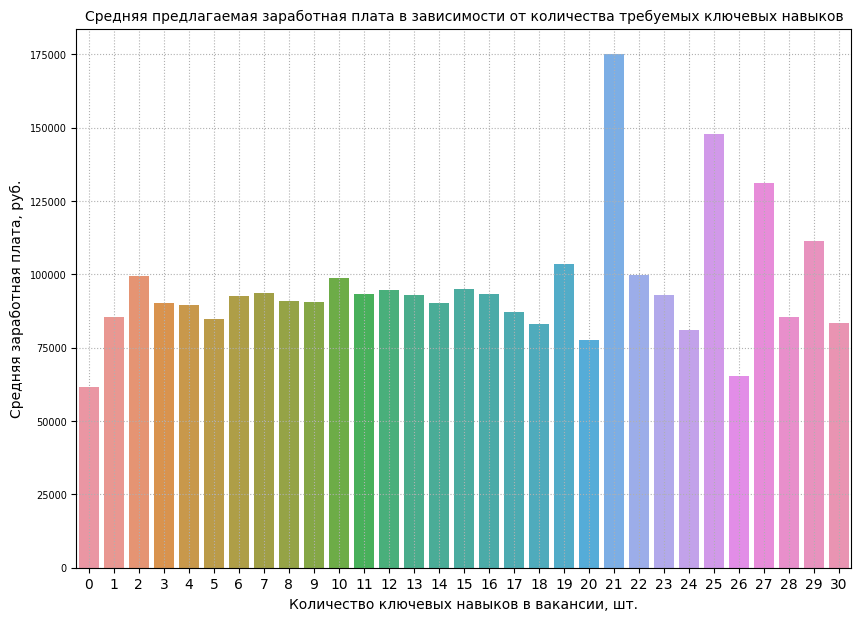

In [345]:
# Выводим столбчатую диаграмму средней заработной платы в зависимости от количества навыков
fig, axes = plt.subplots(figsize=(10, 7))
barplot = sns.barplot(
    data=mean_salary_by_key_skills,
    x='cnt_key_skills',
    y='mean_salary',
    orient='v'
)
barplot.set_title('Средняя предлагаемая заработная плата в зависимости от количества требуемых ключевых навыков', fontsize=10)
barplot.tick_params(axis='y', labelsize=7)
barplot.set_xlabel('Количество ключевых навыков в вакансии, шт.', fontsize=10)
barplot.set_ylabel('Средняя заработная плата, руб.', fontsize=10)
barplot.grid(linestyle=':')

**Вывод**: исходя из полученной диаграммы можно сделать вывод, что количество навыков, указанное в вакансии не оказывает влияния на среднюю заработную плату, что логично, так как разные ключевые навыки имеют разный вес при оценки оплаты труда.

In [346]:
# Закрываем соединение с базой данных
connection.close()